# 1. 데이터 로드

In [1]:
import pandas as pd
import numpy as np

total_data = pd.read_csv('rating_aladin.csv')
total_data['rating'] = total_data['rating'].replace(8.0, np.nan) # 8점 제거
total_data['label'] = np.select([total_data.rating >= 8.], [1], default=0)
total_data = total_data.append(total_data)

naver_movie_data = pd.read_table('rating_naver_movie.txt', names=['ISBN13', 'review', 'label'])
naver_movie_data['label'] = naver_movie_data['label'].apply(lambda x: 1 if x == '1' else 0)
total_data = total_data.append(naver_movie_data)

In [4]:
import pandas as pd
import numpy as np

total_data = pd.read_table('rating_naver_movie.txt', names=['ISBN13', 'review', 'label'])
total_data['label'] = total_data['label'].apply(lambda x: 1 if x == '1' else 0)

In [5]:
# 중복 제거, null 제거, 라벨 정수형 타입 정의
total_data.drop_duplicates(subset=['review'], inplace=True)
total_data['review'].replace('', np.nan, inplace=True)
total_data['review'].dropna(how = 'any', inplace=True)
total_data = total_data.astype({'label': 'int'})

194545
   label  count
0      0  97278
1      1  97267


<AxesSubplot:>

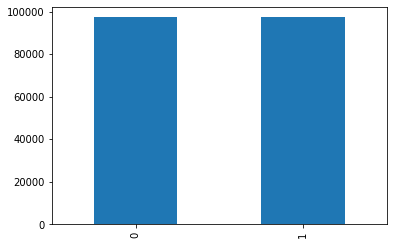

In [6]:
print(len(total_data))
print(total_data.groupby('label').size().reset_index(name = 'count'))
total_data['label'].value_counts().plot(kind = 'bar')

# 2. 전처리

In [7]:
import re
def clean_text(reviews):
    corpus = []
    for review in reviews:
        # review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(review)) #remove punctuation
        # review = re.sub(r'\d+','', str(review))# remove number
        # review = re.sub(r'[a-z]','', str(review).lower())# remove number
        # review = re.sub(r'<[^>]+>','',review) #remove Html tags
        # review = re.sub(r'\[[^>]+\]','',review) #remove Html tags
        # review = re.sub(r'\{[^>]+\}','',review) #remove Html tags
        # review = re.sub(r'\([^>]+\)','',review) #remove Html tags

        review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣"]', ' ', str(review)) #한글, 숫자, 기본 구두점 제외

        review = re.sub(r'\s+', ' ', str(review)) #remove spaces
        review = re.sub(r"^\s+", '', str(review)) #remove space from start
        review = re.sub(r'\s+$', '', str(review)) #remove space from the end
        corpus.append(review)
    return corpus

total_data['cleaned'] = clean_text(total_data['review'])
for sent in total_data['cleaned'][:10]:
    print(sent)


어릴때보고 지금다시봐도 재밌어요ㅋㅋ
디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다
폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고
와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지
안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화
사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화
완전 감동입니다 다시봐도 감동
개들의 전쟁 나오나요 나오면 빠로 보고 싶음
굿


In [9]:
# 외래어 사전 로드
import pandas as pd
lownword_data = pd.read_table('./loanwords.txt', sep='\t', header=None)
lines = lownword_data.values
lownword_map = {}
for line in lines:
    miss_spell = line[0]
    ori_word = line[1]
    lownword_map[miss_spell] = ori_word


# 외래어 정규화
import re
def lownword_normalize(reviews):
    corpus = []
    for review in reviews:
        for lownword in lownword_map:
            review = re.sub(lownword, lownword_map[lownword], str(review))
        corpus.append(review)
    return corpus


def custom_repeat_noramlize1(review):
    sent = review[:]
    i = 0
    while i < len(sent) - 1:
        if sent[i] == sent[i + 1]:
            sent = sent[:i] + sent[i + 1:]
        else:
            i += 1
    return sent


def my_repeat_noramlize(reviews):
    corpus = []
    for review in reviews:
        normalized_sent = custom_repeat_noramlize1(str(review))
        corpus.append(normalized_sent)
    return corpus

In [10]:
from soynlp.normalizer import repeat_normalize
def nomalize(reviews):
    corpus = []
    for review in reviews:
        review = repeat_normalize(review)
        # for lownword in lownword_map:
        #     review = re.sub(lownword, lownword_map[lownword], review)
        corpus.append(review)
    return corpus

total_data['nomalized'] = nomalize(total_data['cleaned'])
for sent in total_data['nomalized'][:10]:
    print(sent)


어릴때보고 지금다시봐도 재밌어요ㅋㅋ
디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다
폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고
와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지
안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화
사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화
완전 감동입니다 다시봐도 감동
개들의 전쟁 나오나요 나오면 빠로 보고 싶음
굿


In [11]:
from konlpy.tag import Mecab # pip install konlpy; pip install mecab_python-0.996_ko_0.9.2_msvc-cp37-cp37m-win_amd64
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
def my_pos_text(reviews):
    corpus = []
    for review in reviews:
        pos_tagged = ''
        for lex, tag in mecab.pos(str(review)):
            pos_tagged += lex + '/' + tag + ' '
        corpus.append(pos_tagged.rstrip())
    return corpus

total_data['tokenized'] = my_pos_text(total_data['nomalized'])
for sent in total_data['tokenized'][:10]:
    print(sent)


어릴/VA+ETM 때/NNG 보/VV 고/EC 지금/MAG 다시/MAG 봐도/VV+EC 재밌/VA 어요/EF ㅋㅋ/IC
디자인/NNG 을/JKO 배우/VV 는/ETM 학생/NNG 으로/JKB 외국/NNG 디자이너/NNG 와/JC 그/NP 들/XSN 이/JKS 일군/VV+ETM 전통/NNG 을/JKO 통해/VV+EC 발전/NNG 해/XSV+EC 가/VX 는/ETM 문화/NNG 산업/NNG 이/JKS 부러웠/VA+EP 는데/EC 사실/MAG 우리/NP 나라/NNG 에서/JKB 도/JX 그/MM 어려운/VA+ETM 시절/NNG 에/JKB 끝/NNG 까지/JX 열정/NNG 을/JKO 지킨/VV+ETM 노라노/NNP 같/VA 은/ETM 전통/NNG 이/JKS 있/VV 어/EC 저/NP 와/JKB 같/VA 은/ETM 사람/NNG 들/XSN 이/JKS 꿈/NNG 을/JKO 꾸/VV 고/EC 이뤄나갈/VV+EC+VX+ETM 수/NNB 있/VV 다는/ETM 것/NNB 에/JKB 감사/NNG 합니다/XSV+EC
폴리스/NNP 스토리/NNG 시리즈/NNG 는/JX 부터/JX 뉴/NNG 까지/JX 버릴/VV+ETM 께/NNB 하나/NR 도/JX 없/VA 음/ETN 최고/NNG
와/IC 연기/NNG 가/JKS 진짜/MAG 개/NNG 쩔/VV 구나/EF 지루/XR 할거/XSA+ETM+NNB+VCP 라고/EC 생각/NNG 했/XSV+EP 는데/EC 몰입/NNG 해서/XSV+EC 봤/VX+EP 다/EF 그래/IC 이런/MM 게/NNB+JKS 진짜/MAG 영화/NNG 지/VCP+EC
안개/NNG 자욱/XR 한/XSA+ETM 밤하늘/NNG 에/JKB 떠/VV+EC 있/VX 는/ETM 초승달/NNG 같/VA 은/ETM 영화/NNG
사랑/NNG 을/JKO 해/VV+EC 본/VX+ETM 사람/NNG 이/VCP 라면/EC 처음/NNG 부터/JX 끝/NNG 까지/JX 웃/VV 을/ETM 수/NNB 있/VV 는/ETM 영화/NNG
완전/MAG 감동/NNG 입니다/VCP+EF 다시/MAG 봐도/VV+E

In [11]:
# from konlpy.tag import Mecab # pip install konlpy; pip install mecab_python-0.996_ko_0.9.2_msvc-cp37-cp37m-win_amd64
# mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
# significant_tags = ['NNG', 'NNP', 'NNB', 'VV', 'VA', 'VX', 'MAG', 'MAJ', 'XSV', 'XSA', 'EC']
# def pos_text(reviews):
#     corpus = []
#     for review in reviews:
#         pos_tagged = ''
#         for lex, tag in mecab.pos(str(review)):
#             if tag in significant_tags:
#                 pos_tagged += lex + '/' + tag + ' '
#         corpus.append(pos_tagged.rstrip())
#     return corpus

# total_data['tokenized'] = pos_text(total_data['nomalized'])
# for sent in total_data['tokenized'][:10]:
#     print(sent)

In [13]:
# import re
# p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
# p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
# p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
# p4 = re.compile('[가-힣A-Za-z0-9]+/VX')
# def stemming_text(reviews):
#     corpus = []
#     for review in reviews:
#         ori_sent = str(review)
#         mached_terms = re.findall(p1, ori_sent)
#         for terms in mached_terms:
#             ori_terms = terms
#             modi_terms = ''
#             for term in terms.split(' '):
#                 lemma = term.split('/')[0]
#                 tag = term.split('/')[-1]
#                 modi_terms += lemma
#             modi_terms += '다/VV'
#             ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
#         mached_terms = re.findall(p2, ori_sent)
#         for terms in mached_terms:
#             ori_terms = terms
#             modi_terms = ''
#             for term in terms.split(' '):
#                 lemma = term.split('/')[0]
#                 tag = term.split('/')[-1]
#                 if tag != 'VX':
#                     modi_terms += lemma
#             modi_terms += '다/VV'
#             ori_sent = ori_sent.replace(ori_terms, modi_terms)

#         mached_terms = re.findall(p3, ori_sent)
#         for terms in mached_terms:
#             ori_terms = terms
#             modi_terms = ''
#             for term in terms.split(' '):
#                 lemma = term.split('/')[0]
#                 tag = term.split('/')[-1]
#                 modi_terms += lemma
#             if '다' != modi_terms[-1]:
#                 modi_terms += '다'
#             modi_terms += '/VV'
#             ori_sent = ori_sent.replace(ori_terms, modi_terms)

#         mached_terms = re.findall(p4, ori_sent)
#         for terms in mached_terms:
#             ori_terms = terms
#             modi_terms = ''
#             for term in terms.split(' '):
#                 lemma = term.split('/')[0]
#                 tag = term.split('/')[-1]
#                 modi_terms += lemma
#             if '다' != modi_terms[-1]:
#                 modi_terms += '다'
#             modi_terms += '/VV'
#             ori_sent = ori_sent.replace(ori_terms, modi_terms)
#         corpus.append(ori_sent)
#     return corpus

# total_data['stemmed'] = stemming_text(total_data['tokenized'])
# for sent in total_data['stemmed'][:100]:
#     print(sent)

In [12]:
stopwords = ['데/NNB', '좀/MAG', '수/NNB', '등/NNB']
def clean_stopword_text(reviews):
    corpus = []
    for review in reviews:
        modi_sent = []
        for word in str(review).split(' '):
            if word not in stopwords:
                modi_sent.append(word)
        corpus.append(' '.join(modi_sent))
    return corpus

# total_data['stopword'] = clean_stopword_text(total_data['stemmed'])
total_data['stopword'] = clean_stopword_text(total_data['tokenized'])
for sent in total_data['stopword'][:10]:
    print(sent)


어릴/VA+ETM 때/NNG 보/VV 고/EC 지금/MAG 다시/MAG 봐도/VV+EC 재밌/VA 어요/EF ㅋㅋ/IC
디자인/NNG 을/JKO 배우/VV 는/ETM 학생/NNG 으로/JKB 외국/NNG 디자이너/NNG 와/JC 그/NP 들/XSN 이/JKS 일군/VV+ETM 전통/NNG 을/JKO 통해/VV+EC 발전/NNG 해/XSV+EC 가/VX 는/ETM 문화/NNG 산업/NNG 이/JKS 부러웠/VA+EP 는데/EC 사실/MAG 우리/NP 나라/NNG 에서/JKB 도/JX 그/MM 어려운/VA+ETM 시절/NNG 에/JKB 끝/NNG 까지/JX 열정/NNG 을/JKO 지킨/VV+ETM 노라노/NNP 같/VA 은/ETM 전통/NNG 이/JKS 있/VV 어/EC 저/NP 와/JKB 같/VA 은/ETM 사람/NNG 들/XSN 이/JKS 꿈/NNG 을/JKO 꾸/VV 고/EC 이뤄나갈/VV+EC+VX+ETM 있/VV 다는/ETM 것/NNB 에/JKB 감사/NNG 합니다/XSV+EC
폴리스/NNP 스토리/NNG 시리즈/NNG 는/JX 부터/JX 뉴/NNG 까지/JX 버릴/VV+ETM 께/NNB 하나/NR 도/JX 없/VA 음/ETN 최고/NNG
와/IC 연기/NNG 가/JKS 진짜/MAG 개/NNG 쩔/VV 구나/EF 지루/XR 할거/XSA+ETM+NNB+VCP 라고/EC 생각/NNG 했/XSV+EP 는데/EC 몰입/NNG 해서/XSV+EC 봤/VX+EP 다/EF 그래/IC 이런/MM 게/NNB+JKS 진짜/MAG 영화/NNG 지/VCP+EC
안개/NNG 자욱/XR 한/XSA+ETM 밤하늘/NNG 에/JKB 떠/VV+EC 있/VX 는/ETM 초승달/NNG 같/VA 은/ETM 영화/NNG
사랑/NNG 을/JKO 해/VV+EC 본/VX+ETM 사람/NNG 이/VCP 라면/EC 처음/NNG 부터/JX 끝/NNG 까지/JX 웃/VV 을/ETM 있/VV 는/ETM 영화/NNG
완전/MAG 감동/NNG 입니다/VCP+EF 다시/MAG 봐도/VV+EC 감동/NNG
개/N

In [13]:
total_data['preprocessed'] = [str(sent).split() for sent in total_data['stopword']]
for sent in total_data['preprocessed'][:10]:
    print(sent)

[]
['어릴/VA+ETM', '때/NNG', '보/VV', '고/EC', '지금/MAG', '다시/MAG', '봐도/VV+EC', '재밌/VA', '어요/EF', 'ㅋㅋ/IC']
['디자인/NNG', '을/JKO', '배우/VV', '는/ETM', '학생/NNG', '으로/JKB', '외국/NNG', '디자이너/NNG', '와/JC', '그/NP', '들/XSN', '이/JKS', '일군/VV+ETM', '전통/NNG', '을/JKO', '통해/VV+EC', '발전/NNG', '해/XSV+EC', '가/VX', '는/ETM', '문화/NNG', '산업/NNG', '이/JKS', '부러웠/VA+EP', '는데/EC', '사실/MAG', '우리/NP', '나라/NNG', '에서/JKB', '도/JX', '그/MM', '어려운/VA+ETM', '시절/NNG', '에/JKB', '끝/NNG', '까지/JX', '열정/NNG', '을/JKO', '지킨/VV+ETM', '노라노/NNP', '같/VA', '은/ETM', '전통/NNG', '이/JKS', '있/VV', '어/EC', '저/NP', '와/JKB', '같/VA', '은/ETM', '사람/NNG', '들/XSN', '이/JKS', '꿈/NNG', '을/JKO', '꾸/VV', '고/EC', '이뤄나갈/VV+EC+VX+ETM', '있/VV', '다는/ETM', '것/NNB', '에/JKB', '감사/NNG', '합니다/XSV+EC']
['폴리스/NNP', '스토리/NNG', '시리즈/NNG', '는/JX', '부터/JX', '뉴/NNG', '까지/JX', '버릴/VV+ETM', '께/NNB', '하나/NR', '도/JX', '없/VA', '음/ETN', '최고/NNG']
['와/IC', '연기/NNG', '가/JKS', '진짜/MAG', '개/NNG', '쩔/VV', '구나/EF', '지루/XR', '할거/XSA+ETM+NNB+VCP', '라고/EC', '생각/NNG', '했/XSV+EP', '는데/EC', '몰

# 4. 훈련 데이터와 테스트 데이터 분리

In [14]:
# 훈련 데이터와 테스트 데이터 분리
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

X_train = train_data['preprocessed'].values
y_train = train_data['label'].values
X_test = test_data['preprocessed'].values
y_test = test_data['label'].values

print(len(train_data))
print(train_data.groupby('label').size().reset_index(name = 'count'))

145908
   label  count
0      0  72891
1      1  73017


# 5. 정수 인코딩

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
def below_threshold_freq(X_train, max_freq):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    threshold = max_freq
    
    total_cnt = len(tokenizer.word_index)
    rare_cnt = 0
    total_freq = 0
    rare_freq = 0

    for key, value in tokenizer.word_counts.items():
        total_freq += value
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

    vocab_size = total_cnt - rare_cnt + 2
    print('단어 집합의 크기 :',vocab_size)


    return vocab_size

max_freq = 2
vocab_size = below_threshold_freq(X_train, max_freq = max_freq)

단어 집합(vocabulary)의 크기 : 55390
등장 빈도가 1번 이하인 희귀 단어의 수: 22845
단어 집합에서 희귀 단어의 비율: 41.243906842390324
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.9527193475217413
단어 집합의 크기 : 32547


In [17]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145152
145152


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
_X_train = tokenizer.texts_to_sequences(X_train)
_X_test = tokenizer.texts_to_sequences(X_test)

# 6. 패딩

리뷰의 최대 길이 : 2016
리뷰의 평균 길이 : 22.13132428366573


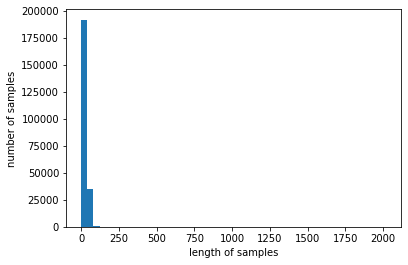

In [22]:
import matplotlib.pyplot as plt
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(X_train, max_len):
    cnt = 0
    for sent in X_train:
        if(len(sent) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(X_train))*100))
    
max_len = 60
below_threshold_len(_X_train, max_len=max_len)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 93.09662264997492


In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(_X_train, maxlen = max_len)
X_test = pad_sequences(_X_test, maxlen = max_len)

# 7. 모델 학습

In [28]:
# GRU 모델 구현
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('gru_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# GRU 모델 학습
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
3032/3032 [==============================] - 172s 56ms/step - loss: 0.4753 - acc: 0.7755 - val_loss: 0.4113 - val_acc: 0.8193

Epoch 00001: val_acc improved from -inf to 0.81930, saving model to gru_best_model.h5
Epoch 2/15
3032/3032 [==============================] - 176s 58ms/step - loss: 0.3858 - acc: 0.8308 - val_loss: 0.3862 - val_acc: 0.8307

Epoch 00002: val_acc improved from 0.81930 to 0.83065, saving model to gru_best_model.h5
Epoch 3/15
3032/3032 [==============================] - 189s 62ms/step - loss: 0.3569 - acc: 0.8469 - val_loss: 0.3897 - val_acc: 0.8305

Epoch 00003: val_acc did not improve from 0.83065
Epoch 4/15
3032/3032 [==============================] - 197s 65ms/step - loss: 0.3324 - acc: 0.8608 - val_loss: 0.3846 - val_acc: 0.8318

Epoch 00004: val_acc improved from 0.83065 to 0.83182, saving model to gru_best_model.h5
Epoch 5/15
3032/3032 [==============================] - 198s 65ms/step - loss: 0.3066 - acc: 0.8727 - val_loss: 0.3985 - val_acc: 0.82

NameError: name 'history' is not defined

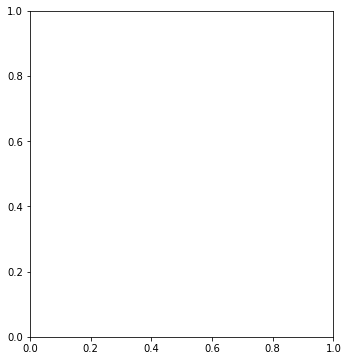

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 6))
plt.subplot(1, 4, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title(' Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 8. 모델 평가

In [92]:
# GRU 모델 평가
loaded_model = load_model('gru_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

2377/2377 [==============================] - 28s 12ms/step - loss: 0.3964 - acc: 0.8218

 테스트 정확도: 0.8218


# 9. 모델 테스트

In [61]:
# from konlpy.tag import Mecab # pip install konlpy; pip install mecab_python-0.996_ko_0.9.2_msvc-cp37-cp37m-win_amd64
# mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
# significant_tags = ['NNG', 'NNP', 'NNB', 'VV', 'VA', 'VX', 'MAG', 'MAJ', 'XSV', 'XSA']
# def pos_tag_text(reviews):
#     corpus = []
#     for review in reviews:
#         pos_tagged = ''
#         for lex, tag in mecab.pos(str(review)):
#             print(lex, tag )
#             if tag in significant_tags:
#                 pos_tagged += lex + '/' + tag + ' '
#         corpus.append(pos_tagged.rstrip())
#     return corpus

In [97]:
def preprocess(reviews):
    reviews = clean_text(reviews)
    print(reviews)
    
    reviews = nomalize(reviews)
    print(reviews)
    
    reviews = my_pos_text(reviews)
    print(reviews)
    
    reviews = stemming_text(reviews)
    print(reviews)
    
    reviews = clean_stopword_text(reviews)
    print(reviews)
    
    return [str(review).split() for review in reviews]

In [98]:
# GRU 모델 테스트
def sentiment_predict(new_sentence):
    # 전처리
    new_sentence = preprocess([new_sentence])
    new_sentence = new_sentence[0]

    # 정수 인코딩, tokenizer 위에 존재
    encoded = tokenizer.texts_to_sequences([new_sentence])

    # 패딩, max_len 위에 존재
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    
    # 예측
#     loaded_model = load_model('gru_best_model.h5')
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [99]:
sentiment_predict("이게 책이냐?")

['이게 책이냐']
['이게 책이냐']
['이게/NP+JKS 책/NNG 이/VCP 냐/EC']
['이게/NP+JKS 책/NNG 이/VCP 냐/EC']
['이게/NP+JKS 책/NNG 이/VCP 냐/EC']
78.66% 확률로 부정 리뷰입니다.


In [100]:
sentiment_predict("이게 책이다")

['이게 책이다']
['이게 책이다']
['이게/NP+JKS 책/NNG 이/VCP 다/EC']
['이게/NP+JKS 책/NNG 이/VCP 다/EC']
['이게/NP+JKS 책/NNG 이/VCP 다/EC']
62.06% 확률로 긍정 리뷰입니다.


In [101]:
sentiment_predict("괜찮습니다.")

['괜찮습니다']
['괜찮습니다']
['괜찮/VA 습니다/EF']
['괜찮/VA 습니다/EF']
['괜찮/VA 습니다/EF']
87.10% 확률로 긍정 리뷰입니다.


In [102]:
sentiment_predict("시간만 아깝네")

['시간만 아깝네']
['시간만 아깝네']
['시간/NNG 만/JX 아깝/VA 네/EC']
['시간/NNG 만/JX 아깝/VA 네/EC']
['시간/NNG 만/JX 아깝/VA 네/EC']
96.11% 확률로 부정 리뷰입니다.
